# Apple Mobility Data

The CSV file and charts on this site show a relative volume of directions requests per country/region, sub-region or city compared to a baseline volume on 13 January 2020. We define our day as midnight-to-midnight, US Pacific time. Cities are defined as the greater metropolitan area and their geographic boundaries remain constant across the data set. In many countries/regions, sub-regions and cities, relative volume has increased since 13 January, consistent with normal, seasonal usage of Apple Maps. Day of week effects are important to normalise as you use this data. Data that is sent from users’ devices to the Maps service is associated with random, rotating identifiers so Apple does not have a profile of individual movements and searches. Apple Maps has no demographic information about users, so we cannot make any statements about the representativeness of our usage against the overall population.

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import requests
import os
import numpy as np

In [2]:
# Go to repository root directory
if "_changed_dir" not in locals():
    os.chdir("../")
    _changed_dir = True

## Data download

In [3]:
raw_data_dir = 'data/raw'
if not os.path.exists(raw_data_dir):
    os.makedirs(raw_data_dir)

In [4]:

file_name = 'Apple-mobilitytrends.csv'
url = "https://covid19-static.cdn-apple.com/covid19-mobility-data/2010HotfixDev18/v3/en-us/applemobilitytrends-2020-06-14.csv"

file_path = os.path.join(raw_data_dir, file_name)

myfile = requests.get(url)
open(file_path, 'wb').write(myfile.content)

3710113

## Preprocess data

Transforms from wide to long dataset

In [5]:
apple_mob_raw = pd.read_csv(file_path) #, parse_dates=['date'])

In [6]:
apple_mob_raw.columns

Index(['geo_type', 'region', 'transportation_type', 'alternative_name',
       'sub-region', 'country', '2020-01-13', '2020-01-14', '2020-01-15',
       '2020-01-16',
       ...
       '2020-06-05', '2020-06-06', '2020-06-07', '2020-06-08', '2020-06-09',
       '2020-06-10', '2020-06-11', '2020-06-12', '2020-06-13', '2020-06-14'],
      dtype='object', length=160)

In [7]:
id_vars = apple_mob_raw.columns[:6]
date_vars = apple_mob_raw.columns[6:]
print(f"new columns {id_vars}")

new columns Index(['geo_type', 'region', 'transportation_type', 'alternative_name',
       'sub-region', 'country'],
      dtype='object')


In [8]:
apple_mob = apple_mob_raw.melt(id_vars=id_vars, value_vars=date_vars, var_name="date", value_name='mobility')

In [9]:
apple_mob_raw.head(10)

,geo_type,region,transportation_type,alternative_name,sub-region,country,2020-01-13,2020-01-14,2020-01-15,2020-01-16,...,2020-06-05,2020-06-06,2020-06-07,2020-06-08,2020-06-09,2020-06-10,2020-06-11,2020-06-12,2020-06-13,2020-06-14
0,country/region,Albania,driving,NaN,NaN,NaN,100.0,95.30,101.43,97.20,...,93.46,102.16,111.59,93.78,95.51,92.69,96.27,115.30,126.24,129.96
1,country/region,Albania,walking,NaN,NaN,NaN,100.0,100.68,98.93,98.46,...,83.24,81.96,87.25,87.38,90.83,91.09,89.13,97.74,97.95,77.91
2,country/region,Argentina,driving,NaN,NaN,NaN,100.0,97.07,102.45,111.21,...,52.26,47.48,27.32,44.06,47.00,48.10,49.36,56.59,52.09,30.96
3,country/region,Argentina,walking,NaN,NaN,NaN,100.0,95.11,101.37,112.67,...,37.34,33.53,19.60,34.36,35.81,36.25,36.61,41.45,35.27,21.26
4,country/region,Australia,driving,AU,NaN,NaN,100.0,102.98,104.21,108.63,...,104.34,83.85,85.16,86.92,88.07,90.36,98.28,100.97,81.74,86.30
5,country/region,Australia,transit,AU,NaN,NaN,100.0,101.78,100.64,99.58,...,51.44,41.01,39.83,44.71,44.55,45.98,48.26,53.46,43.97,46.04
6,country/region,Australia,walking,AU,NaN,NaN,100.0,101.31,101.82,104.52,...,86.54,67.91,58.85,60.79,61.07,65.38,69.20,84.38,67.10,63.27
7,country/region,Austria,driving,Österreich,NaN,NaN,100.0,101.14,104.24,112.21,...,114.00,107.45,103.32,108.74,113.08,126.42,125.28,131.90,118.86,114.42
8,country/region,Austria,walking,Österreich,NaN,NaN,100.0,101.55,105.59,112.24,...,84.65,92.45,64.72,80.21,84.13,82.75,93.81,112.65,95.66,58.08
9,country/region,Belgium,driving,België|Belgique,NaN,NaN,100.0,101.19,107.49,107.67,...,106.04,100.57,97.59,104.70,107.53,111.90,113.06,115.65,114.56,106.48


In [10]:
dat_columns = apple_mob.mobility.unique()
id_columns = [c for c in apple_mob.columns if c not in  ["mobility", "transportation_type"]]
apple_mob["date"] = pd.to_datetime(apple_mob.date)
apple_mob = pd.concat(
    [
        apple_mob[id_columns],
        apple_mob.pivot(columns="transportation_type", values="mobility")
    ],
    axis=1, sort=False
)


In [11]:
apple_mob[id_columns] = apple_mob[id_columns].fillna('')
apple_mob_proc = apple_mob.groupby(id_columns, as_index=False).first()

In [12]:
# Types of regions
for geo_type in apple_mob_proc.geo_type.unique():
    val = np.sum(apple_mob_proc.geo_type==geo_type)
    print(f"{geo_type}: {val}")

city: 46046
country/region: 9702
county: 321860
sub-region: 91784


Based on this let's remove counties, which are a very small US specific denomination:

In [13]:
apple_mob_proc = apple_mob_proc[apple_mob_proc.geo_type != 'county']
apple_mob_proc.drop(columns='alternative_name', inplace=True)

In [14]:
apple_mob_proc.sample(10)

,geo_type,region,sub-region,country,date,driving,transit,walking
33266,city,Prague,,Czech Republic,2020-01-15,104.85,NaN,NaN
414560,sub-region,KwaZulu-Natal,,South Africa,2020-06-07,61.32,NaN,NaN
33937,city,Raleigh,North Carolina,United States,2020-03-10,112.02,89.32,103.00
26379,city,Modesto,California,United States,2020-02-27,110.59,89.35,101.14
434908,sub-region,Okayama Prefecture,,Japan,2020-01-25,144.78,NaN,NaN
40128,city,Syracuse,New York,United States,2020-04-10,60.17,41.26,40.47
388590,sub-region,Canton of Aargau,,Switzerland,2020-03-01,101.60,NaN,NaN
43308,city,Tulsa,Oklahoma,United States,2020-02-16,89.43,82.63,94.49
3317,city,Bangkok,,Thailand,2020-04-05,33.63,NaN,18.58
46547,country/region,Austria,,,2020-02-21,142.35,NaN,142.40


In [15]:
apple_mob = apple_mob_proc

## Dataset features


In [16]:
# Types of regions
for geo_type in apple_mob.geo_type.unique():
    val = np.sum(apple_mob.geo_type==geo_type)
    print(f"{geo_type}: {val}")

city: 46046
country/region: 9702
sub-region: 91784


In [17]:
geoid_columns = apple_mob.columns[:4]
data_columns = apple_mob.columns[5:]
print(geoid_columns)
print(data_columns)

Index(['geo_type', 'region', 'sub-region', 'country'], dtype='object')
Index(['driving', 'transit', 'walking'], dtype='object')


In [18]:
print(f"Data in range: {apple_mob.date.min()} to {apple_mob.date.max()}")

Data in range: 2020-01-13 00:00:00 to 2020-06-14 00:00:00


In [20]:
def sum_geo_cols_contents(row, geo_cols):
    out = ""
    for col in geo_cols:
        out += str(row[col]) + '_'
    return out.strip('nan_')
# This is slow avoid to rerun
if "unique_geo_id" not in apple_mob.columns:
    apple_mob["unique_geo_id"] = apple_mob.apply(
        lambda x: sum_geo_cols_contents(x, geoid_columns), axis=1
    )

In [21]:
print(f"Unique unique_geo_id in dataset: {len(apple_mob.unique_geo_id.unique())}") 

Unique unique_geo_id in dataset: 958


In [22]:
apple_mob["unique_geo_id"] = apple_mob["unique_geo_id"].str.strip('nan_')

## Reindex data

Use a multi index to separate date and geography information

In [23]:
index_cols = ["unique_geo_id", "date"]
apple_mob.set_index(
    pd.MultiIndex.from_frame(apple_mob[index_cols]
), inplace=True)

Add a helper function to explore the available geo_ids

In [24]:
def find_matching_geo_id(
    apple_mob, 
    find_str='FR_France', 
    exclude_str='This garbage is not a country name'
):
    return [
        name for name in apple_mob.unique_geo_id.unique()
            if find_str in name 
            if exclude_str not in name
    ]

## Plotting data for Apple 

In [25]:
print(find_matching_geo_id(apple_mob, 'country/region_United Kingdom', 'nan_'))

['country/region_United Kingdom']


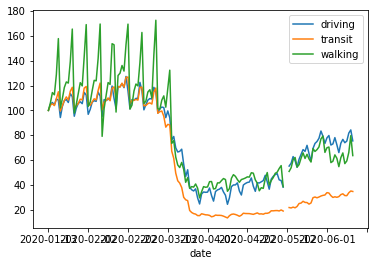

In [26]:
apple_mob.loc['country/region_United Kingdom'].plot(y=data_columns)

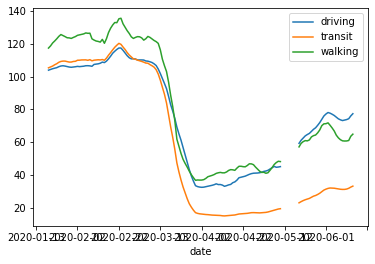

In [27]:
apple_mob.loc['country/region_United Kingdom', data_columns].rolling(7).mean().plot()